In [30]:
from IPython.core.display import display, HTML
import random
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_941/2154100854.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [31]:
import pandas as pd

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [33]:
from functools import partial

import torch

from pyro.nn import AutoRegressiveNN, ConditionalAutoRegressiveNN

from pyro.distributions import constraints
from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.distributions.transforms import SplineCoupling
from pyro.distributions.transforms.spline import ConditionalSpline



import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
#from data_utils.data_loader import HDF5Dataset, MaxwellBatchLoader, MaxwellBatchLoaderFullyCond

from torch.nn.parallel import DistributedDataParallel as DDP
from torch.multiprocessing import Process

#import ML_models.models as models
#import ML_models.functions as functions
import time
import h5py

from custom_pyro import ConditionalAffineCouplingTanH

from pyro.nn import ConditionalDenseNN, DenseNN, ConditionalAutoRegressiveNN
import pyro.distributions as dist
import pyro.distributions.transforms as T
device = torch.device('cuda:0')

In [34]:
def compile_HybridTanH_model(num_blocks, num_inputs, num_cond_inputs, device):
    # the latent space distribution: choosing a 2-dim Gaussian
    base_dist = dist.Normal(torch.zeros(num_inputs).to(device), torch.ones(num_inputs).to(device))

    input_dim = num_inputs
    count_bins = 8
    transforms = []
    transforms2 = []
      
    input_dim = num_inputs
    split_dim = num_inputs//2
    param_dims1 = [input_dim-split_dim, input_dim-split_dim]
    param_dims2 = [input_dim * count_bins, input_dim * count_bins, input_dim * (count_bins - 1), input_dim * count_bins]

    torch.manual_seed(42)

    for i in range(num_blocks):
        

                    
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        hypernet = DenseNN(num_cond_inputs, [input_dim*4, input_dim*4], param_dims2)
        ctf = T.ConditionalSpline(hypernet, input_dim, count_bins)
        transforms2.append(ctf)
        transforms.append(ctf)
        

        

        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        
    modules = nn.ModuleList(transforms2)

    flow_dist = dist.ConditionalTransformedDistribution(base_dist, transforms)

    return modules, flow_dist

In [35]:
model, distribution = compile_HybridTanH_model(8, 
                                           num_inputs=35, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=device)  # num_cond_inputs

In [36]:
default_params = {
    "batch_size" : 2048,
    "epochs" : 500,
    "shuffle" : True,
}

In [37]:
kwargs = {}
params = {}
for param in default_params.keys():

    if param in kwargs.keys():
        params[param] = kwargs[param]
    else:
        params[param] = default_params[param]

In [38]:
path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5'
energy = h5py.File(path, 'r')['energy'][:]
events = h5py.File(path, 'r')['events'][:]

num_points = (events[:][:, -1] > 0).sum(axis=1)
visible_energy = (events[:][:, -1]).sum(axis=1)

In [39]:
clusters_per_layer = [((events[:, 1, :] < i+1) & (events[:, 1, :] > i)).sum(axis=1) for i in range(30)]

clusters_per_layer = np.vstack(clusters_per_layer)

clusters_per_layer = np.moveaxis(clusters_per_layer, 0, -1)

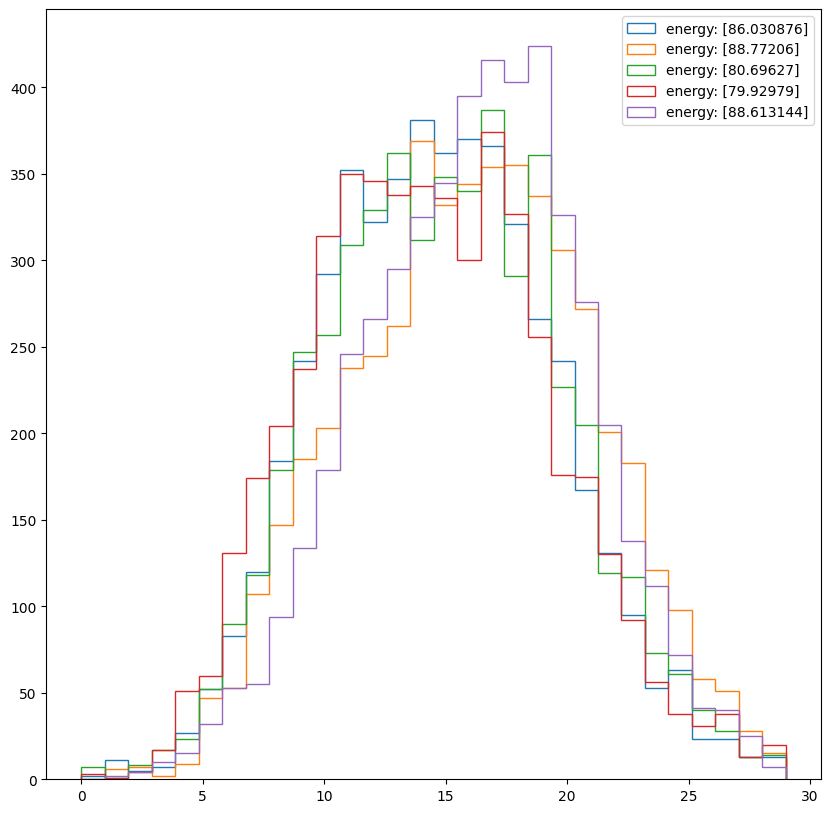

In [40]:
plt.figure(figsize=(10,10))
for i in range(500000, 500005):
    plt.hist(np.arange(30), weights=clusters_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=30)
plt.legend()
plt.show()

In [41]:
# center of gravity 

def get_cog(x,y,z,e):
    return np.sum((x * e), axis=1) / e.sum(axis=1), np.sum((y * e), axis=1) / e.sum(axis=1), np.sum((z * e), axis=1) / e.sum(axis=1)

cog = get_cog(
    events[:, 0],
    events[:, 1],
    events[:, 2],
    events[:, 3],
)


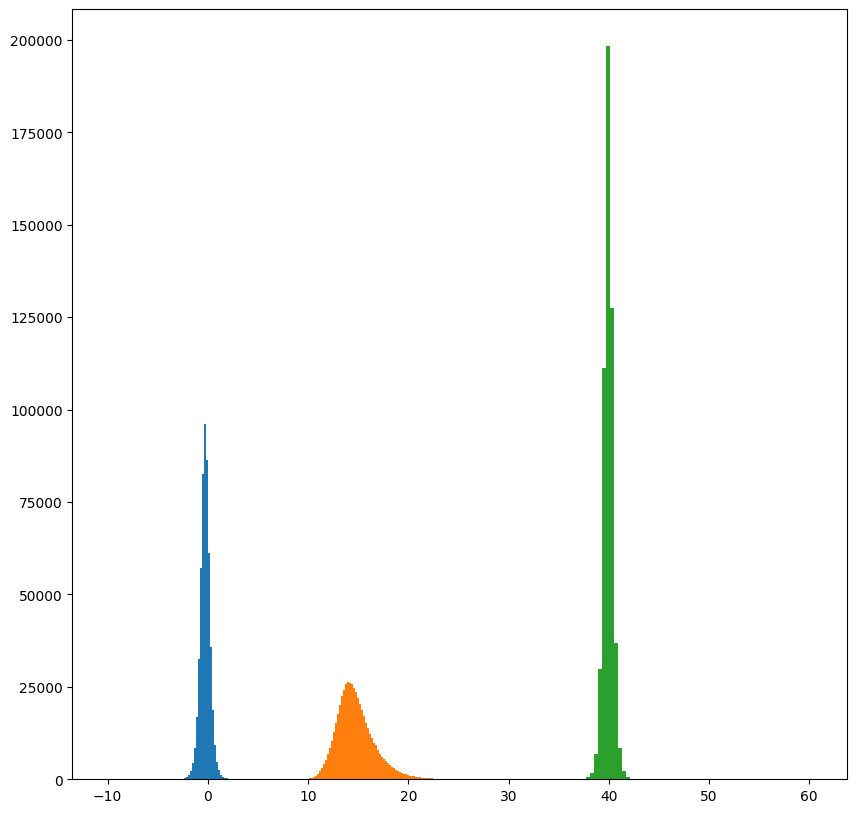

In [42]:
plt.figure(figsize=(10,10))
plt.hist(cog[0], bins=100, range=(-10, 10), label='x')
plt.hist(cog[1], bins=100) 
plt.hist(cog[2], bins=100)
# plt.xlim(-10, 10)
plt.show()

In [43]:
clusters_per_layer = clusters_per_layer / 400

df = pd.DataFrame([])
df['energy'] = energy[:].reshape(-1)
df['num_points'] = num_points / 5000
df['visible_energy'] = visible_energy * 1000 / 2.5 / 1000

df['clusters_per_layer'] = clusters_per_layer.tolist()

df['cog_x'] = cog[0]
df['cog_y'] = cog[1] - 15
df['cog_z'] = cog[2] - 40

In [44]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(df.energy.values), 
    torch.tensor(df.num_points.values), 
    torch.tensor(df.visible_energy.values),
    torch.tensor(df.clusters_per_layer),
    torch.tensor(df.cog_x.values),
    torch.tensor(df.cog_y.values),
    torch.tensor(df.cog_z.values),
    )

In [45]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=params["batch_size"], shuffle=params["shuffle"], pin_memory=True)


In [46]:
num_blocks = 10

In [47]:
batch = next(iter(train_loader))

In [48]:
for item in batch:
    print(item.shape)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 30])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])


In [49]:
output_path = '/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/'
prefix = '220706_cog_'
outpath = output_path + prefix

In [50]:
from tqdm import tqdm

In [51]:
lr = 5e-5
                   
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
                   

torch.manual_seed(41)

losses = []
for epoch in range(1, params["epochs"]+1):
    input_list = []
#     for batch_idx, (mu, logvar, e, theta, e_sum) in enumerate(train_loader):
    for batch_idx, (energy, num_points, visible_energy, clusters_per_layer, cog_x, cog_y, cog_z) in enumerate(tqdm(train_loader)):

        E_true = energy.view(-1, 1).to(device).float()
        energy_sum = visible_energy.view(-1,1).to(device).float()
        num_points = num_points.view(-1, 1).to(device).float()
        clusters_per_layer = clusters_per_layer.to(device).float()
        cog_x = cog_x.view(-1, 1).to(device).float()
        cog_y = cog_y.view(-1, 1).to(device).float()
        cog_z = cog_z.view(-1, 1).to(device).float()
   
        
        # normalise conditional labels
        E_true = (E_true/100).float()

        input_data = torch.cat((energy_sum, num_points, clusters_per_layer, cog_x, cog_y, cog_z), 1)   #### input data structure required for network with additional features in latent space (e.g. Esum)
        
        #input_data = torch.cat((z), 1)
        #input_data = z

        optimizer.zero_grad()

        # try to add context for conditioning by concatenating 
        context = E_true
        #print(theta_true.size())
        
        #nll = -distribution.condition(E_true).log_prob(input_data) ## solution   # does this work, or do need spearate .condition for each label?
        
        if np.any(np.isnan(input_data.clone().detach().cpu().numpy())) == True:
            print('Nans in the training data!')
            
        #### check if any of the weights are nans
        #for param in model.parameters():
        #    if np.any(np.isnan(param.weight.clone().detach().cpu().numpy())) == True:
        #        print('Weights are nan!')
            
        nll = -distribution.condition(context).log_prob(input_data)
        loss = nll.mean()
        #print(loss.item())
        loss.backward()

        optimizer.step() 

        distribution.clear_cache()
        
        input_list.append(input_data.detach().cpu().numpy())

    print(epoch, loss.item())
    losses.append(loss.item())
    #############################
    # Log to COMET ML
    #############################

    if epoch%10 == 0:
        torch.save(
            {'model': model.state_dict()}, 
            outpath+f'ShowerFlow_{epoch}.pth'
        )
        print('model saved')



 32%|███▏      | 82/257 [00:23<00:48,  3.61it/s]

100%|██████████| 257/257 [01:15<00:00,  3.38it/s]


1 -57.080570220947266


100%|██████████| 257/257 [01:18<00:00,  3.29it/s]


2 -64.73905944824219


100%|██████████| 257/257 [01:19<00:00,  3.24it/s]


3 -66.92207336425781


100%|██████████| 257/257 [01:18<00:00,  3.27it/s]


4 -66.59498596191406


100%|██████████| 257/257 [01:12<00:00,  3.57it/s]


5 -68.03759765625


100%|██████████| 257/257 [01:10<00:00,  3.66it/s]


6 -67.75071716308594


100%|██████████| 257/257 [01:18<00:00,  3.28it/s]


7 -68.66935729980469


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


8 -69.25533294677734


100%|██████████| 257/257 [01:17<00:00,  3.33it/s]


9 -69.71504974365234


100%|██████████| 257/257 [01:18<00:00,  3.28it/s]


10 -67.97899627685547
model saved


100%|██████████| 257/257 [01:11<00:00,  3.59it/s]


11 -69.2399673461914


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


12 -69.18309783935547


100%|██████████| 257/257 [01:13<00:00,  3.48it/s]


13 -69.8174057006836


100%|██████████| 257/257 [01:15<00:00,  3.43it/s]


14 -69.74504852294922


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


15 -69.67362213134766


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


16 -68.83718872070312


100%|██████████| 257/257 [01:16<00:00,  3.37it/s]


17 -69.3187026977539


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


18 -69.96357727050781


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


19 -70.63851928710938


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


20 -70.76048278808594
model saved


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


21 -70.61493682861328


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


22 -69.08988189697266


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


23 -69.74669647216797


100%|██████████| 257/257 [01:11<00:00,  3.58it/s]


24 -70.81969451904297


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


25 -71.1454086303711


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


26 -70.65438842773438


100%|██████████| 257/257 [01:17<00:00,  3.30it/s]


27 -70.66481018066406


100%|██████████| 257/257 [01:16<00:00,  3.38it/s]


28 -70.75345611572266


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


29 -71.37348937988281


100%|██████████| 257/257 [01:13<00:00,  3.52it/s]


30 -70.78034973144531
model saved


100%|██████████| 257/257 [01:12<00:00,  3.54it/s]


31 -71.24905395507812


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


32 -70.52312469482422


100%|██████████| 257/257 [01:11<00:00,  3.62it/s]


33 -71.32381439208984


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


34 -70.29204559326172


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


35 -70.8187026977539


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


36 -71.5494155883789


100%|██████████| 257/257 [01:16<00:00,  3.35it/s]


37 -71.74030303955078


100%|██████████| 257/257 [01:15<00:00,  3.38it/s]


38 -71.64834594726562


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


39 -70.49944305419922


100%|██████████| 257/257 [01:18<00:00,  3.27it/s]


40 -71.17880249023438
model saved


100%|██████████| 257/257 [01:16<00:00,  3.36it/s]


41 -71.54800415039062


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


42 -71.34194946289062


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


43 -69.43002319335938


100%|██████████| 257/257 [01:13<00:00,  3.52it/s]


44 -71.2175521850586


100%|██████████| 257/257 [01:13<00:00,  3.48it/s]


45 -71.68014526367188


100%|██████████| 257/257 [01:11<00:00,  3.58it/s]


46 -69.45111083984375


100%|██████████| 257/257 [01:12<00:00,  3.52it/s]


47 -71.56770324707031


100%|██████████| 257/257 [01:12<00:00,  3.55it/s]


48 -70.61408996582031


100%|██████████| 257/257 [01:16<00:00,  3.37it/s]


49 -69.31800842285156


100%|██████████| 257/257 [01:11<00:00,  3.61it/s]


50 -69.65852355957031
model saved


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


51 -71.37590789794922


100%|██████████| 257/257 [01:12<00:00,  3.55it/s]


52 -72.0295639038086


100%|██████████| 257/257 [01:11<00:00,  3.59it/s]


53 -72.03996276855469


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


54 -71.25080108642578


100%|██████████| 257/257 [01:11<00:00,  3.60it/s]


55 -71.24851989746094


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


56 -71.77993774414062


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


57 -70.76201629638672


100%|██████████| 257/257 [01:17<00:00,  3.30it/s]


58 -71.69692993164062


100%|██████████| 257/257 [01:17<00:00,  3.33it/s]


59 -71.83000946044922


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


60 -71.4982681274414
model saved


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


61 -71.75062561035156


100%|██████████| 257/257 [01:16<00:00,  3.35it/s]


62 -69.9639663696289


100%|██████████| 257/257 [01:19<00:00,  3.23it/s]


63 -71.5966567993164


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


64 -69.5320053100586


100%|██████████| 257/257 [01:10<00:00,  3.67it/s]


65 -71.50765228271484


100%|██████████| 257/257 [01:13<00:00,  3.50it/s]


66 -71.88570404052734


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


67 -71.71077728271484


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


68 -72.08529663085938


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


69 -71.40328979492188


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


70 -70.54703521728516
model saved


100%|██████████| 257/257 [01:13<00:00,  3.50it/s]


71 -70.5499038696289


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


72 -71.62674713134766


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


73 -70.60951232910156


100%|██████████| 257/257 [01:15<00:00,  3.38it/s]


74 -71.53726959228516


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


75 -71.97608184814453


100%|██████████| 257/257 [01:16<00:00,  3.36it/s]


76 -71.28013610839844


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


77 -67.00785827636719


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


78 -71.08467102050781


100%|██████████| 257/257 [01:13<00:00,  3.52it/s]


79 -71.73714447021484


100%|██████████| 257/257 [01:15<00:00,  3.38it/s]


80 -71.98553466796875
model saved


100%|██████████| 257/257 [01:16<00:00,  3.36it/s]


81 -71.93529510498047


100%|██████████| 257/257 [01:16<00:00,  3.35it/s]


82 -70.8052749633789


100%|██████████| 257/257 [01:09<00:00,  3.68it/s]


83 -70.64456939697266


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


84 -71.77918243408203


100%|██████████| 257/257 [01:12<00:00,  3.52it/s]


85 -71.1501235961914


100%|██████████| 257/257 [01:17<00:00,  3.33it/s]


86 -65.8396224975586


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


87 -70.63007354736328


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


88 -70.1830062866211


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


89 -71.30652618408203


100%|██████████| 257/257 [01:19<00:00,  3.24it/s]


90 -70.88581848144531
model saved


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


91 -72.5955810546875


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


92 -70.47053527832031


100%|██████████| 257/257 [01:19<00:00,  3.25it/s]


93 -69.92134094238281


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


94 -71.21566772460938


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


95 -71.22968292236328


100%|██████████| 257/257 [01:16<00:00,  3.35it/s]


96 -70.56475067138672


100%|██████████| 257/257 [01:11<00:00,  3.58it/s]


97 -72.11052703857422


100%|██████████| 257/257 [01:13<00:00,  3.52it/s]


98 -72.34428405761719


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


99 -71.07396697998047


100%|██████████| 257/257 [01:10<00:00,  3.67it/s]


100 -71.62212371826172
model saved


100%|██████████| 257/257 [01:10<00:00,  3.65it/s]


101 -72.22239685058594


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


102 -71.42002868652344


100%|██████████| 257/257 [01:19<00:00,  3.25it/s]


103 -71.83521270751953


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


104 -71.85944366455078


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


105 -71.8213119506836


100%|██████████| 257/257 [01:17<00:00,  3.30it/s]


106 -70.73941802978516


100%|██████████| 257/257 [01:16<00:00,  3.35it/s]


107 -72.16446685791016


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


108 -72.30294036865234


100%|██████████| 257/257 [01:11<00:00,  3.62it/s]


109 -72.09683227539062


100%|██████████| 257/257 [01:24<00:00,  3.06it/s]


110 -71.19447326660156
model saved


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


111 -70.61251068115234


100%|██████████| 257/257 [01:13<00:00,  3.51it/s]


112 -71.63641357421875


100%|██████████| 257/257 [01:08<00:00,  3.73it/s]


113 -72.88099670410156


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


114 -72.03345489501953


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


115 -72.09773254394531


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


116 -72.05859375


100%|██████████| 257/257 [01:11<00:00,  3.62it/s]


117 -72.10558319091797


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


118 -71.29085540771484


100%|██████████| 257/257 [01:10<00:00,  3.64it/s]


119 -71.80379486083984


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


120 -71.49957275390625
model saved


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


121 -69.3407974243164


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


122 -71.7401123046875


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


123 -70.25212097167969


100%|██████████| 257/257 [01:12<00:00,  3.54it/s]


124 -71.8843765258789


100%|██████████| 257/257 [01:12<00:00,  3.54it/s]


125 -69.18309020996094


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


126 -71.65483856201172


100%|██████████| 257/257 [01:13<00:00,  3.52it/s]


127 -71.87398529052734


100%|██████████| 257/257 [01:11<00:00,  3.59it/s]


128 -71.62528228759766


100%|██████████| 257/257 [01:12<00:00,  3.55it/s]


129 -72.23831939697266


100%|██████████| 257/257 [01:13<00:00,  3.50it/s]


130 -72.08710479736328
model saved


100%|██████████| 257/257 [01:11<00:00,  3.62it/s]


131 -72.57535552978516


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


132 -70.71202087402344


100%|██████████| 257/257 [01:13<00:00,  3.51it/s]


133 -71.64112091064453


100%|██████████| 257/257 [01:19<00:00,  3.22it/s]


134 -71.26892852783203


100%|██████████| 257/257 [01:11<00:00,  3.59it/s]


135 -72.38836669921875


100%|██████████| 257/257 [01:12<00:00,  3.57it/s]


136 -73.21694946289062


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


137 -71.28404998779297


100%|██████████| 257/257 [01:16<00:00,  3.35it/s]


138 -72.0267333984375


100%|██████████| 257/257 [01:17<00:00,  3.33it/s]


139 -72.50077819824219


100%|██████████| 257/257 [01:12<00:00,  3.52it/s]


140 -71.85787200927734
model saved


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


141 -72.03240203857422


100%|██████████| 257/257 [01:16<00:00,  3.38it/s]


142 -72.79912567138672


100%|██████████| 257/257 [01:12<00:00,  3.52it/s]


143 -71.50225830078125


100%|██████████| 257/257 [01:10<00:00,  3.66it/s]


144 -72.09354400634766


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


145 -72.52661895751953


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


146 -72.42756652832031


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


147 -70.34469604492188


100%|██████████| 257/257 [01:11<00:00,  3.57it/s]


148 -72.14125061035156


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


149 -72.48289489746094


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


150 -70.53277587890625
model saved


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


151 -71.08700561523438


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


152 -66.36724853515625


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


153 -72.25283813476562


100%|██████████| 257/257 [01:16<00:00,  3.34it/s]


154 -72.03323364257812


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


155 -71.26119995117188


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


156 -70.17384338378906


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


157 -73.024169921875


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


158 -72.1540298461914


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


159 -70.0023422241211


100%|██████████| 257/257 [01:17<00:00,  3.30it/s]


160 -73.25265502929688
model saved


100%|██████████| 257/257 [01:11<00:00,  3.59it/s]


161 -70.09312438964844


100%|██████████| 257/257 [01:17<00:00,  3.30it/s]


162 -72.4024887084961


100%|██████████| 257/257 [01:16<00:00,  3.37it/s]


163 -72.72770690917969


100%|██████████| 257/257 [01:12<00:00,  3.53it/s]


164 -71.8998794555664


100%|██████████| 257/257 [01:18<00:00,  3.27it/s]


165 -71.68828582763672


100%|██████████| 257/257 [01:19<00:00,  3.25it/s]


166 -71.36953735351562


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


167 -71.3210678100586


100%|██████████| 257/257 [01:10<00:00,  3.62it/s]


168 -72.99787902832031


100%|██████████| 257/257 [01:12<00:00,  3.53it/s]


169 -70.36481475830078


100%|██████████| 257/257 [01:09<00:00,  3.68it/s]


170 -72.74916076660156
model saved


100%|██████████| 257/257 [01:13<00:00,  3.50it/s]


171 -72.94735717773438


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


172 -69.50955200195312


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


173 -72.29915618896484


100%|██████████| 257/257 [01:13<00:00,  3.51it/s]


174 -72.97511291503906


100%|██████████| 257/257 [01:18<00:00,  3.28it/s]


175 -72.5947036743164


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


176 -73.08525085449219


100%|██████████| 257/257 [01:19<00:00,  3.25it/s]


177 -72.149658203125


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


178 -73.02627563476562


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


179 -68.61915588378906


100%|██████████| 257/257 [01:18<00:00,  3.28it/s]


180 -72.114501953125
model saved


100%|██████████| 257/257 [01:13<00:00,  3.51it/s]


181 -72.90811920166016


100%|██████████| 257/257 [01:09<00:00,  3.72it/s]


182 -73.33458709716797


100%|██████████| 257/257 [01:11<00:00,  3.59it/s]


183 -71.50591278076172


100%|██████████| 257/257 [01:16<00:00,  3.34it/s]


184 -73.02947235107422


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


185 -72.05379486083984


100%|██████████| 257/257 [01:16<00:00,  3.36it/s]


186 -73.47042846679688


100%|██████████| 257/257 [01:15<00:00,  3.38it/s]


187 -72.036865234375


100%|██████████| 257/257 [01:11<00:00,  3.60it/s]


188 -73.74504852294922


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


189 -72.44776916503906


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


190 -73.84056091308594
model saved


100%|██████████| 257/257 [01:16<00:00,  3.35it/s]


191 -72.40042114257812


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


192 -72.35975646972656


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


193 -73.45086669921875


100%|██████████| 257/257 [01:17<00:00,  3.30it/s]


194 -71.75404357910156


100%|██████████| 257/257 [01:18<00:00,  3.26it/s]


195 -70.58076477050781


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


196 -71.81605529785156


100%|██████████| 257/257 [01:18<00:00,  3.25it/s]


197 -72.61580657958984


100%|██████████| 257/257 [01:16<00:00,  3.38it/s]


198 -72.96147918701172


100%|██████████| 257/257 [01:13<00:00,  3.51it/s]


199 -73.0663833618164


100%|██████████| 257/257 [01:10<00:00,  3.63it/s]


200 -73.5995864868164
model saved


100%|██████████| 257/257 [01:09<00:00,  3.72it/s]


201 -73.29161071777344


100%|██████████| 257/257 [01:16<00:00,  3.36it/s]


202 -71.9239273071289


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


203 -71.16879272460938


100%|██████████| 257/257 [01:16<00:00,  3.37it/s]


204 -73.47242736816406


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


205 -72.48892974853516


100%|██████████| 257/257 [01:13<00:00,  3.51it/s]


206 -71.9601058959961


100%|██████████| 257/257 [01:12<00:00,  3.55it/s]


207 -73.74732971191406


100%|██████████| 257/257 [01:10<00:00,  3.66it/s]


208 -72.65404510498047


100%|██████████| 257/257 [01:12<00:00,  3.53it/s]


209 -73.01614379882812


100%|██████████| 257/257 [01:11<00:00,  3.62it/s]


210 -72.42205810546875
model saved


100%|██████████| 257/257 [01:16<00:00,  3.34it/s]


211 -71.27908325195312


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


212 -72.36946868896484


100%|██████████| 257/257 [01:16<00:00,  3.37it/s]


213 -72.9460220336914


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


214 -74.07806396484375


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


215 -73.46560668945312


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


216 -72.3543472290039


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


217 -73.25106048583984


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


218 -73.55728149414062


100%|██████████| 257/257 [01:16<00:00,  3.37it/s]


219 -72.50762939453125


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


220 -72.88265228271484
model saved


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


221 -73.25702667236328


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


222 -73.18400573730469


100%|██████████| 257/257 [01:12<00:00,  3.54it/s]


223 -73.01602935791016


100%|██████████| 257/257 [01:16<00:00,  3.38it/s]


224 -72.9513931274414


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


225 -72.53839111328125


100%|██████████| 257/257 [01:18<00:00,  3.27it/s]


226 -73.6848373413086


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


227 -71.88685607910156


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


228 -71.89907836914062


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


229 -72.20162200927734


100%|██████████| 257/257 [01:17<00:00,  3.34it/s]


230 -73.68183898925781
model saved


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


231 -73.00078582763672


100%|██████████| 257/257 [01:10<00:00,  3.65it/s]


232 -72.89971923828125


100%|██████████| 257/257 [01:16<00:00,  3.36it/s]


233 -72.96620178222656


100%|██████████| 257/257 [01:16<00:00,  3.34it/s]


234 -73.3725357055664


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


235 -73.77133178710938


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


236 -73.62044525146484


100%|██████████| 257/257 [01:11<00:00,  3.59it/s]


237 -73.14111328125


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


238 -73.06239318847656


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


239 -72.09551239013672


100%|██████████| 257/257 [01:13<00:00,  3.51it/s]


240 -73.37229919433594
model saved


100%|██████████| 257/257 [01:12<00:00,  3.54it/s]


241 -73.51920318603516


100%|██████████| 257/257 [01:12<00:00,  3.53it/s]


242 -68.64656066894531


100%|██████████| 257/257 [01:12<00:00,  3.53it/s]


243 -74.15857696533203


100%|██████████| 257/257 [01:17<00:00,  3.29it/s]


244 -70.74298858642578


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


245 -72.02783966064453


100%|██████████| 257/257 [01:13<00:00,  3.51it/s]


246 -73.42290496826172


100%|██████████| 257/257 [01:16<00:00,  3.38it/s]


247 -73.73326110839844


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


248 -73.05592346191406


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


249 -73.51575469970703


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


250 -73.05906677246094
model saved


100%|██████████| 257/257 [01:09<00:00,  3.72it/s]


251 -72.32769775390625


100%|██████████| 257/257 [01:10<00:00,  3.64it/s]


252 -72.56415557861328


100%|██████████| 257/257 [01:17<00:00,  3.30it/s]


253 -72.9700927734375


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


254 -72.76728820800781


100%|██████████| 257/257 [01:12<00:00,  3.53it/s]


255 -72.55105590820312


100%|██████████| 257/257 [01:10<00:00,  3.65it/s]


256 -70.78394317626953


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


257 -74.43827819824219


100%|██████████| 257/257 [01:13<00:00,  3.48it/s]


258 -73.3122329711914


100%|██████████| 257/257 [01:15<00:00,  3.38it/s]


259 -72.66500854492188


100%|██████████| 257/257 [01:16<00:00,  3.37it/s]


260 -71.32129669189453
model saved


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


261 -73.64279174804688


100%|██████████| 257/257 [01:17<00:00,  3.33it/s]


262 -73.12906646728516


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


263 -73.21839904785156


100%|██████████| 257/257 [01:13<00:00,  3.52it/s]


264 -74.21261596679688


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


265 -71.91104888916016


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


266 -72.74876403808594


100%|██████████| 257/257 [01:13<00:00,  3.48it/s]


267 -73.94412231445312


100%|██████████| 257/257 [01:12<00:00,  3.57it/s]


268 -72.60249328613281


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


269 -74.11577606201172


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


270 -72.43030548095703
model saved


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


271 -72.51954650878906


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


272 -73.39730072021484


100%|██████████| 257/257 [01:16<00:00,  3.34it/s]


273 -73.34392547607422


100%|██████████| 257/257 [01:16<00:00,  3.35it/s]


274 -73.82694244384766


100%|██████████| 257/257 [01:12<00:00,  3.54it/s]


275 -73.26712799072266


100%|██████████| 257/257 [01:18<00:00,  3.29it/s]


276 -74.37754821777344


100%|██████████| 257/257 [01:14<00:00,  3.43it/s]


277 -73.89897155761719


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


278 -74.12831115722656


100%|██████████| 257/257 [01:16<00:00,  3.37it/s]


279 -74.16197967529297


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


280 -73.44631958007812
model saved


100%|██████████| 257/257 [01:13<00:00,  3.47it/s]


281 -73.63526916503906


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


282 -72.09545135498047


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


283 -71.77104949951172


100%|██████████| 257/257 [01:17<00:00,  3.33it/s]


284 -73.6458740234375


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


285 -69.27881622314453


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


286 -74.05812072753906


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


287 -71.43061065673828


100%|██████████| 257/257 [01:18<00:00,  3.28it/s]


288 -73.61578369140625


100%|██████████| 257/257 [01:17<00:00,  3.33it/s]


289 -74.77298736572266


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


290 -75.19549560546875
model saved


100%|██████████| 257/257 [01:11<00:00,  3.60it/s]


291 -74.4791488647461


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


292 -74.3473129272461


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


293 -73.6365737915039


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


294 -72.3689193725586


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


295 -73.6955795288086


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


296 -72.8965835571289


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


297 -73.71722412109375


100%|██████████| 257/257 [01:13<00:00,  3.52it/s]


298 -70.1491928100586


100%|██████████| 257/257 [01:13<00:00,  3.47it/s]


299 -71.67127227783203


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


300 -73.2371597290039
model saved


100%|██████████| 257/257 [01:09<00:00,  3.72it/s]


301 -73.38738250732422


100%|██████████| 257/257 [01:10<00:00,  3.64it/s]


302 -73.2713394165039


100%|██████████| 257/257 [01:16<00:00,  3.38it/s]


303 -73.20759582519531


100%|██████████| 257/257 [01:16<00:00,  3.36it/s]


304 -68.07596588134766


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


305 -73.29244232177734


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


306 -73.12950897216797


100%|██████████| 257/257 [01:12<00:00,  3.54it/s]


307 -75.18326568603516


100%|██████████| 257/257 [01:15<00:00,  3.41it/s]


308 -74.11646270751953


100%|██████████| 257/257 [01:15<00:00,  3.38it/s]


309 -74.57115936279297


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


310 -75.375244140625
model saved


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


311 -73.77482604980469


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


312 -72.95820617675781


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


313 -72.6416244506836


100%|██████████| 257/257 [01:13<00:00,  3.48it/s]


314 -75.24593353271484


100%|██████████| 257/257 [01:16<00:00,  3.35it/s]


315 -70.52349853515625


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


316 -74.51067352294922


100%|██████████| 257/257 [01:12<00:00,  3.52it/s]


317 -73.99980926513672


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


318 -73.957275390625


100%|██████████| 257/257 [01:15<00:00,  3.42it/s]


319 -74.29357147216797


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


320 -73.8598861694336
model saved


100%|██████████| 257/257 [01:14<00:00,  3.44it/s]


321 -74.22122955322266


100%|██████████| 257/257 [01:14<00:00,  3.45it/s]


322 -73.67608642578125


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


323 -74.95472717285156


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


324 -72.92837524414062


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


325 -74.2353744506836


100%|██████████| 257/257 [01:09<00:00,  3.69it/s]


326 -73.95486450195312


100%|██████████| 257/257 [01:13<00:00,  3.47it/s]


327 -73.82361602783203


100%|██████████| 257/257 [01:11<00:00,  3.60it/s]


328 -74.15663146972656


100%|██████████| 257/257 [01:13<00:00,  3.50it/s]


329 -74.24400329589844


100%|██████████| 257/257 [01:18<00:00,  3.27it/s]


330 -74.28193664550781
model saved


100%|██████████| 257/257 [01:16<00:00,  3.36it/s]


331 -73.54649353027344


100%|██████████| 257/257 [01:17<00:00,  3.30it/s]


332 -73.04474639892578


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


333 -74.92142486572266


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


334 -73.41138458251953


100%|██████████| 257/257 [01:12<00:00,  3.53it/s]


335 -74.80770111083984


100%|██████████| 257/257 [01:13<00:00,  3.49it/s]


336 -74.81996154785156


100%|██████████| 257/257 [01:17<00:00,  3.32it/s]


337 -74.79855346679688


100%|██████████| 257/257 [01:17<00:00,  3.34it/s]


338 -74.63249969482422


100%|██████████| 257/257 [01:12<00:00,  3.57it/s]


339 -74.06192779541016


100%|██████████| 257/257 [01:13<00:00,  3.52it/s]


340 -75.20355987548828
model saved


100%|██████████| 257/257 [01:15<00:00,  3.40it/s]


341 -73.84368133544922


100%|██████████| 257/257 [01:13<00:00,  3.52it/s]


342 -74.1637954711914


100%|██████████| 257/257 [01:10<00:00,  3.62it/s]


343 -74.23831939697266


100%|██████████| 257/257 [01:17<00:00,  3.30it/s]


344 -74.80345916748047


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


345 -72.53952026367188


100%|██████████| 257/257 [01:11<00:00,  3.58it/s]


346 -73.39286041259766


100%|██████████| 257/257 [01:16<00:00,  3.37it/s]


347 -74.54650115966797


100%|██████████| 257/257 [01:17<00:00,  3.31it/s]


348 -75.69496154785156


100%|██████████| 257/257 [01:18<00:00,  3.27it/s]


349 -74.37362670898438


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


350 -74.13473510742188
model saved


100%|██████████| 257/257 [01:14<00:00,  3.47it/s]


351 -74.63045501708984


100%|██████████| 257/257 [01:15<00:00,  3.39it/s]


352 -74.20851135253906


100%|██████████| 257/257 [01:16<00:00,  3.38it/s]


353 -75.1668472290039


100%|██████████| 257/257 [01:11<00:00,  3.58it/s]


354 -73.65218353271484


100%|██████████| 257/257 [01:16<00:00,  3.36it/s]


355 -73.38542938232422


100%|██████████| 257/257 [01:18<00:00,  3.29it/s]


356 -74.84795379638672


100%|██████████| 257/257 [01:13<00:00,  3.48it/s]


357 -74.47926330566406


100%|██████████| 257/257 [01:12<00:00,  3.53it/s]


358 -74.84911346435547


 88%|████████▊ | 227/257 [01:03<00:08,  3.56it/s]


KeyboardInterrupt: 